# Introduction to digital signal processing

Credits to https://github.com/markovka17/apdl/blob/master/week01/

In [1]:
# !pip install torchaudio==0.12.1

In [2]:
from matplotlib import pyplot as plt
from IPython import display

import torch
import torchaudio

import numpy as np

In [3]:
torchaudio.__version__

'2.0.2+cu118'

# Time domain $\rightarrow$  frequency domain

In [5]:
wav, sr = torchaudio.load('c.wav')

In [6]:
wav

tensor([[-8.9844e-01, -9.2413e-01, -9.4107e-01,  ...,  0.0000e+00,
          0.0000e+00, -3.0518e-05],
        [-1.1871e-02, -8.7189e-02, -1.4929e-01,  ..., -3.0518e-05,
          3.0518e-05, -3.0518e-05]])

In [9]:
display.Audio(wav, rate=sr)

In [10]:
def visualize_audio(wav: torch.Tensor, sr: int = 22050):
    # Average all channels
    if wav.dim() == 2:
        # Any to mono audio convertion
        wav = wav.mean(dim=0)

    plt.figure(figsize=(20, 5))
    plt.plot(wav, alpha=.7, c='green')
    plt.grid()
    plt.xlabel('Time', size=20)
    plt.ylabel('Amplitude', size=20)
    plt.show()

    display.display(display.Audio(wav, rate=sr))


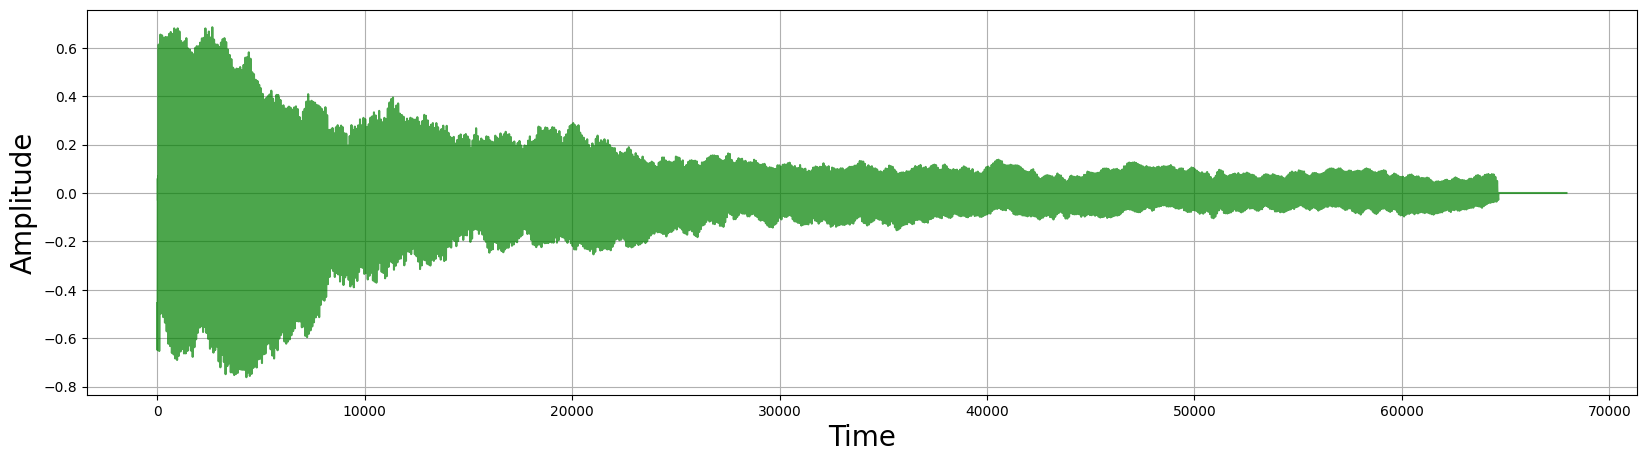

In [11]:
visualize_audio(wav, sr)

In [12]:
n_fft = 1024
ft = torch.fft.fft(wav.mean(dim=0), n=n_fft)

In [13]:
ft.dtype

torch.complex64

In [14]:
magnitude = ft.abs().pow(2)
frequency = np.linspace(0, sr, len(magnitude))

In [15]:
frequency[:5000].shape

(1024,)

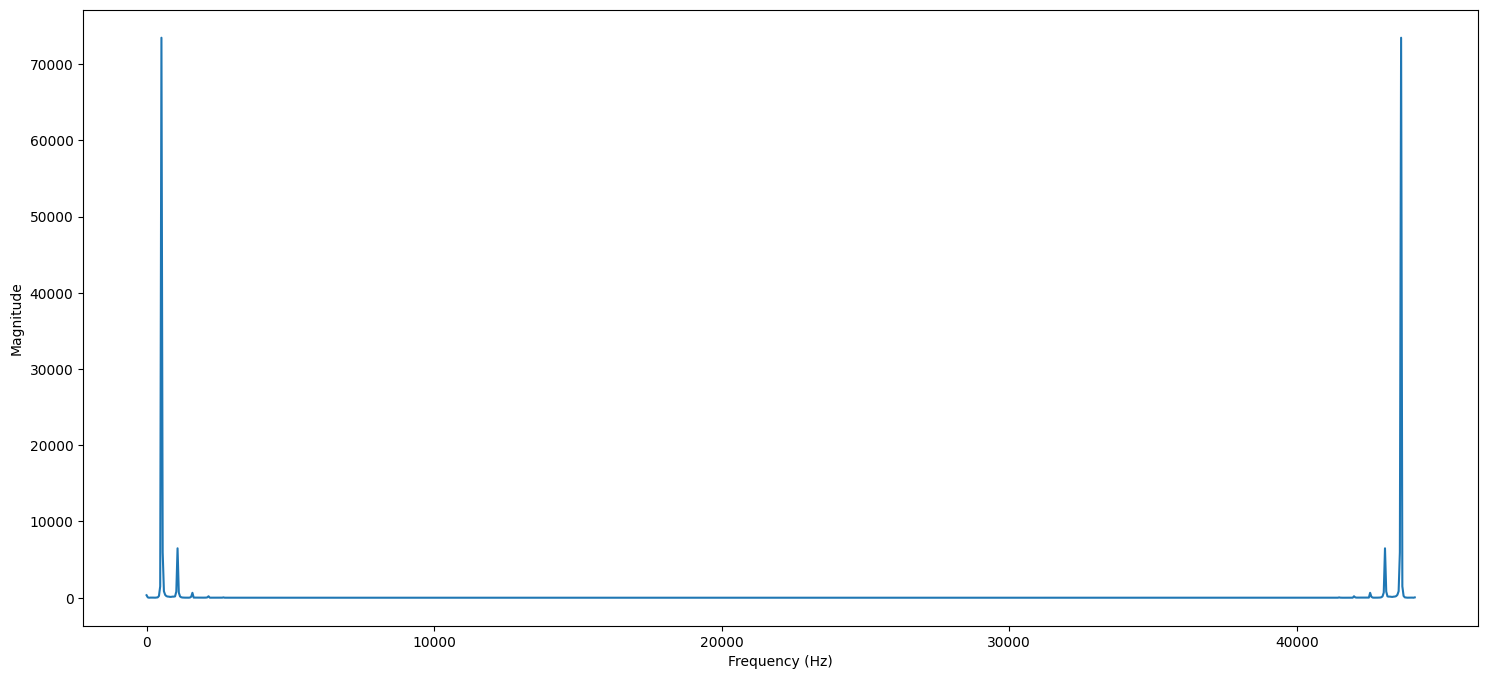

In [16]:
# plot spectrum
plt.figure(figsize=(18, 8))
plt.plot(frequency, magnitude) # magnitude spectrum
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.show()

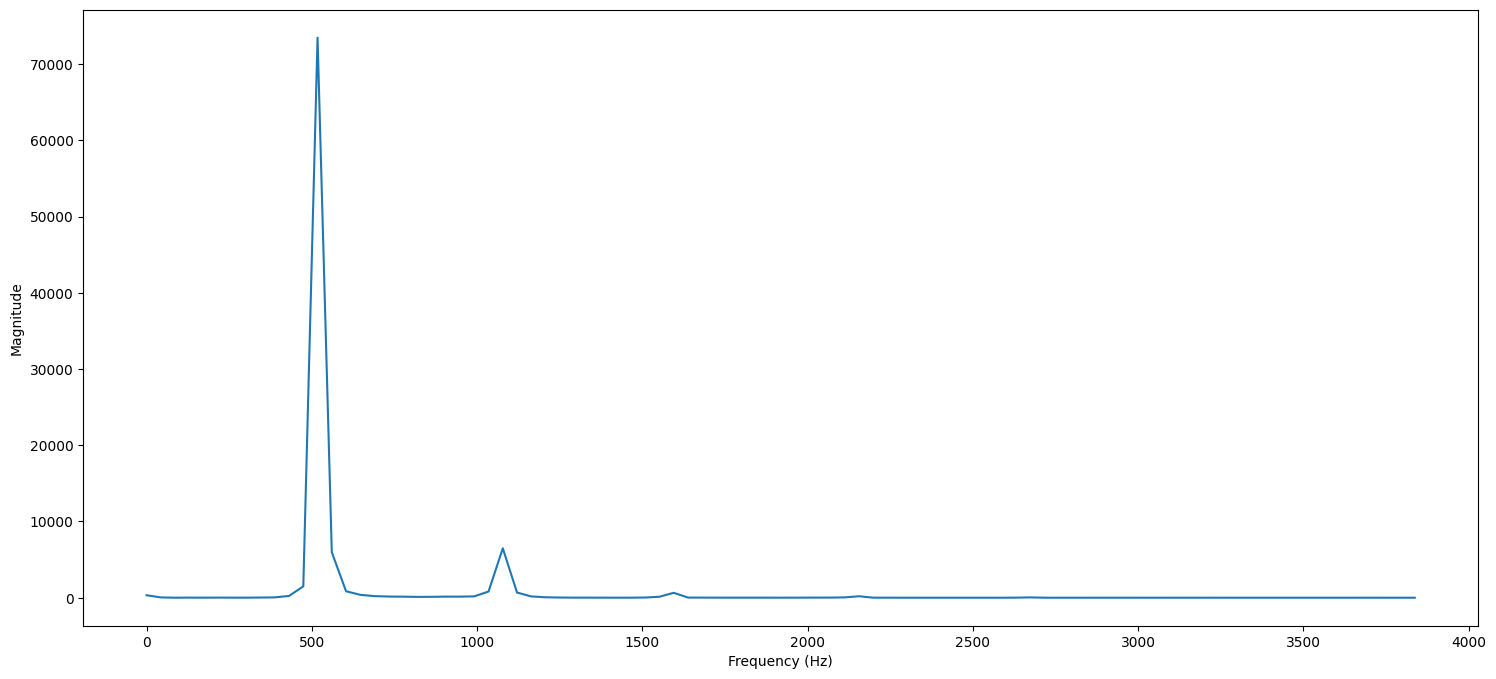

In [17]:
# plot spectrum
plt.figure(figsize=(18, 8))
plt.plot(frequency[:90], magnitude[:90]) # magnitude spectrum
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.show()

In [ ]:
sr

In [18]:
1 / 523 * 44100

84.32122370936902

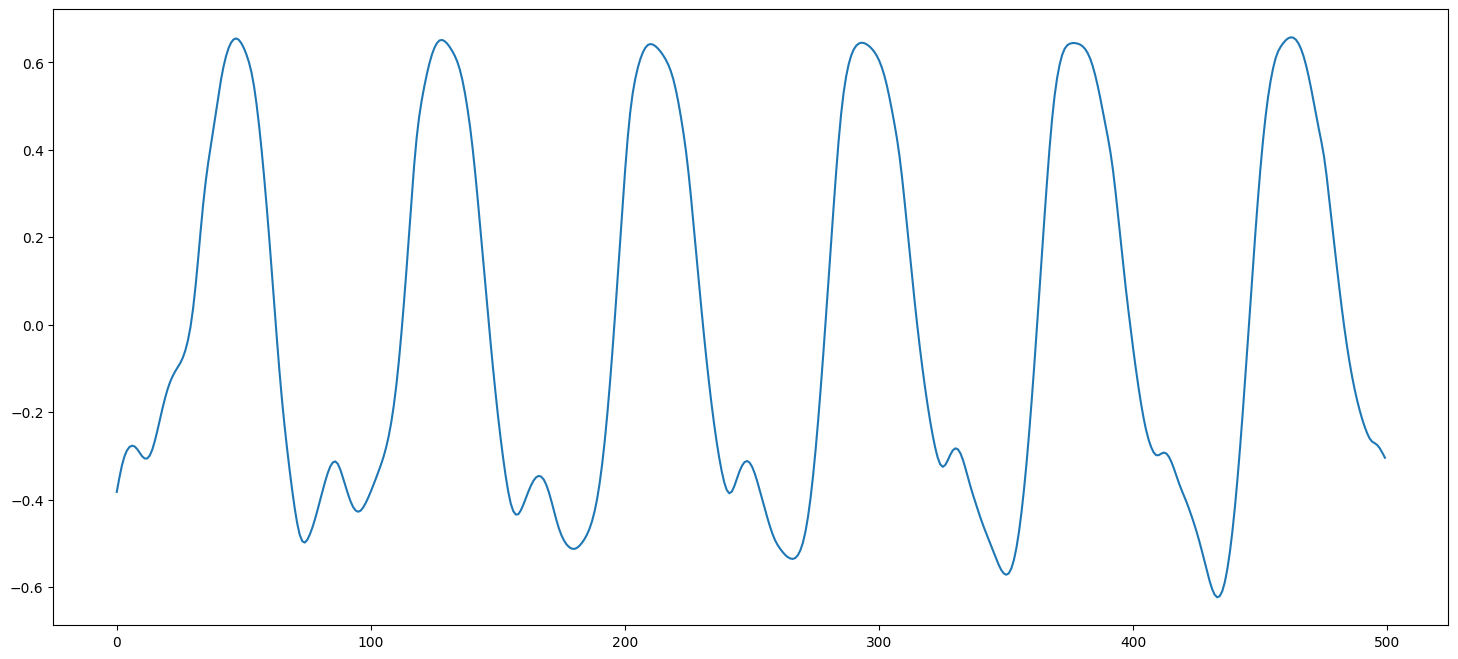

In [19]:
# plot wave
plt.figure(figsize=(18, 8))
plt.plot(wav.mean(0)[100:600])
plt.show()

# Build mel spectrogram

In [28]:
wav, sr = torchaudio.load('example.wav')

In [31]:
display.Audio(wav, rate=sr)

In [32]:
n_fft = 1024

In [33]:
spectrum = torch.fft.rfft(wav, n=n_fft)

In [34]:
spectrum.dtype

torch.complex64

In [35]:
spectrum = torch.fft.rfft(wav.mean(dim=0), n=n_fft)

In [36]:
spectrogram = spectrum.abs().pow(2)

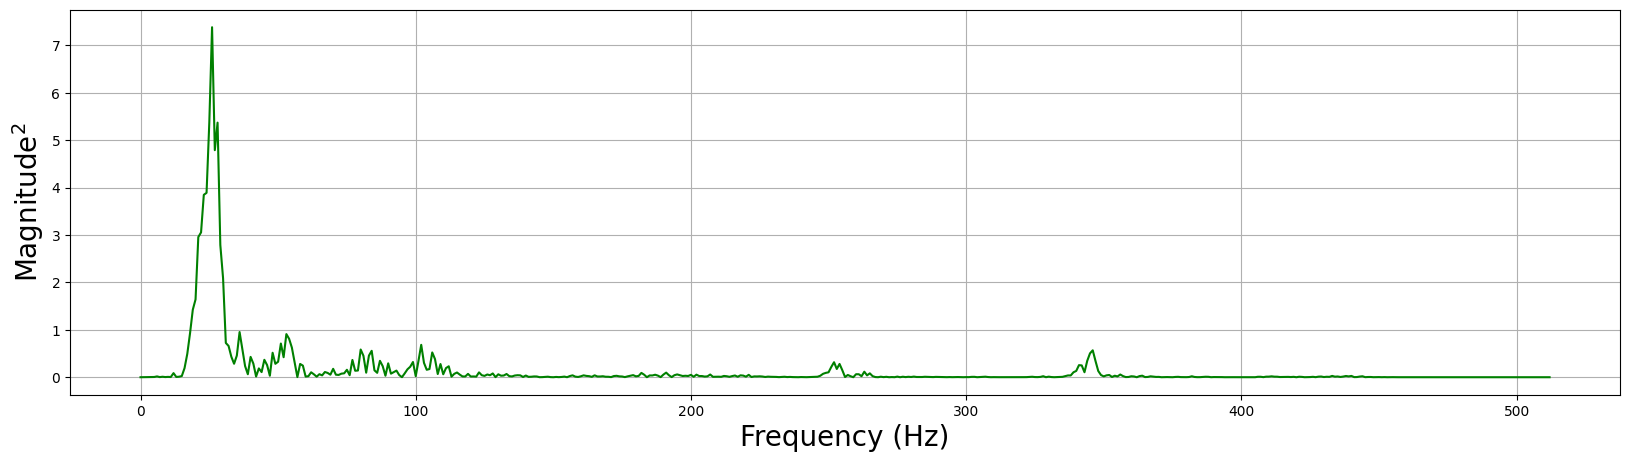

In [37]:
plt.figure(figsize=(20, 5))
plt.plot(spectrogram.squeeze(), c='green')
plt.grid()
plt.xlabel('Frequency (Hz)', size=20)
plt.ylabel('Magnitude$^2$', size=20)
plt.show()


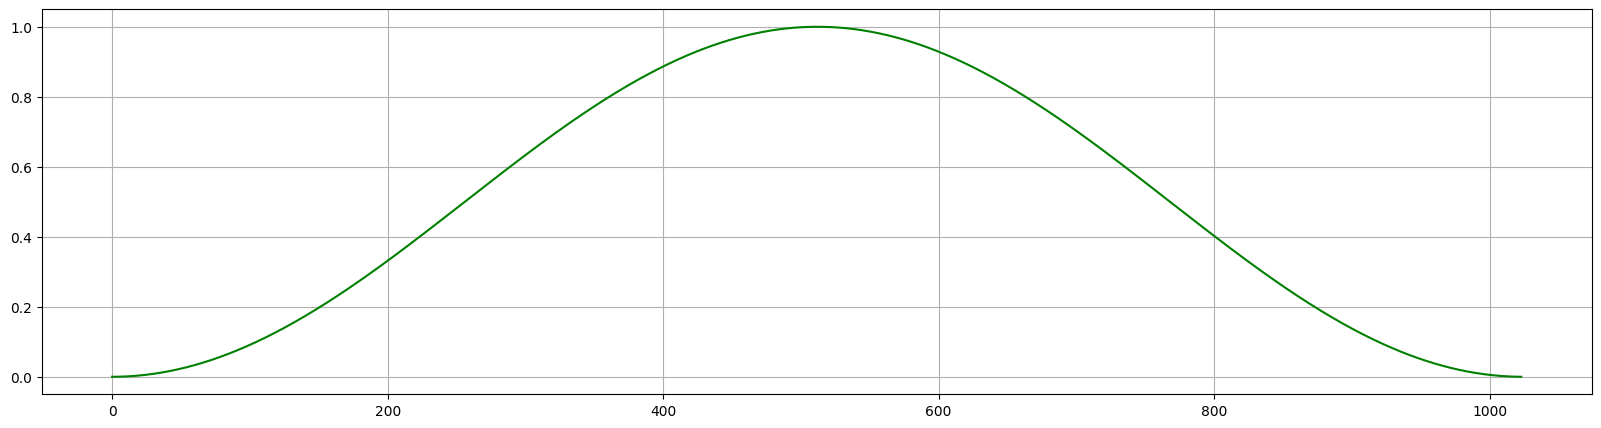

In [38]:
window_size = n_fft
window = torch.hann_window(window_size)

plt.figure(figsize=(20, 5))
plt.plot(window, c='green')
plt.grid()
plt.show()


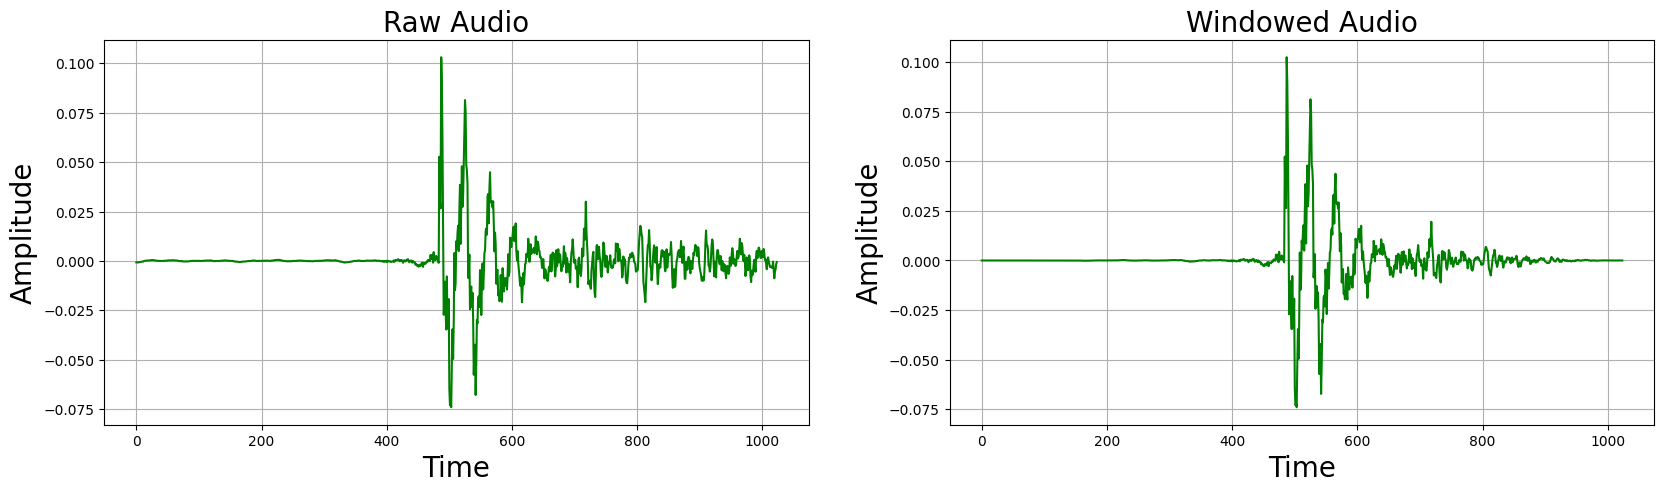

In [39]:
clipped_wav = wav[:, :window_size]
windowed_clipped_wav = window * clipped_wav

fig, axes = plt.subplots(1, 2, figsize=(20, 5))

axes[0].plot(clipped_wav.squeeze(), c='green')
axes[0].set_title('Raw Audio', size=20)

axes[1].plot(windowed_clipped_wav.squeeze(), c='green')
axes[1].set_title('Windowed Audio', size=20)

for i in range(2):
    axes[i].grid()
    axes[i].set_xlabel('Time', size=20)
    axes[i].set_ylabel('Amplitude', size=20)

plt.show()


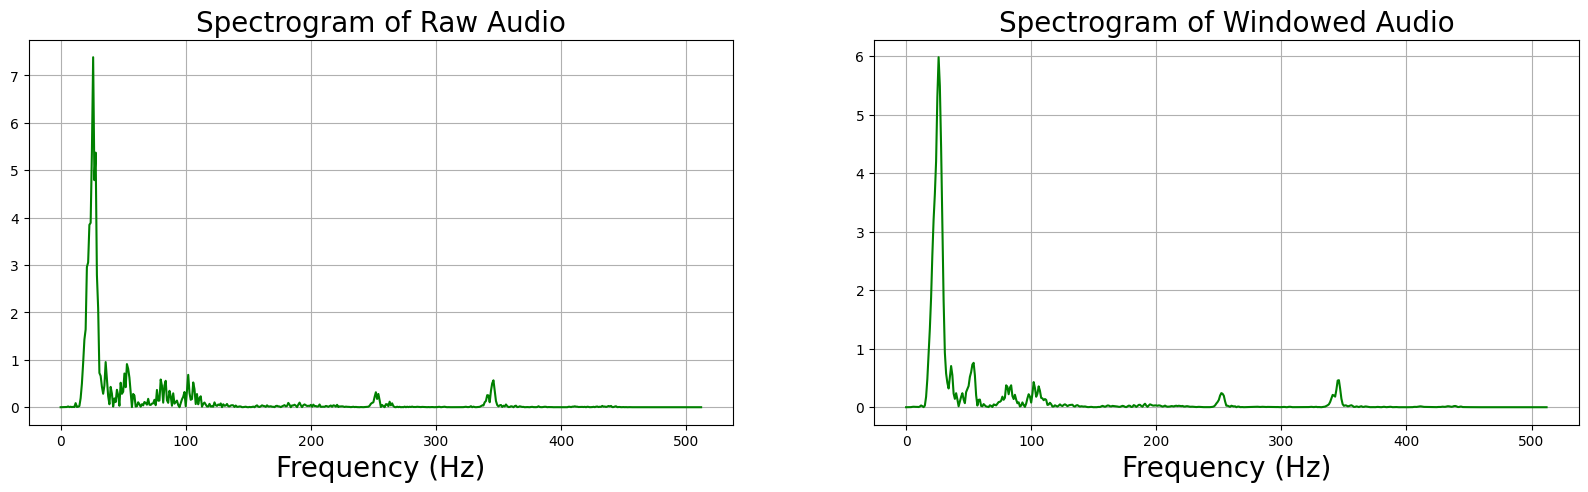

In [40]:
spectrogram = torch.fft.rfft(clipped_wav).abs().pow(2)
windowed_spectrogram = torch.fft.rfft(windowed_clipped_wav).abs().pow(2)

fig, axes = plt.subplots(1, 2, figsize=(20, 5))

axes[0].plot(spectrogram.squeeze(), c='green')
axes[0].set_title('Spectrogram of Raw Audio', size=20)

axes[1].plot(windowed_spectrogram.squeeze(), c='green')
axes[1].set_title('Spectrogram of Windowed Audio', size=20)

for i in range(2):
    axes[i].grid()
    axes[i].set_xlabel('Frequency (Hz)', size=20)

plt.show()


In [43]:
spectrum = torch.stft(
    wav,
    n_fft=1024,
    hop_length=256,
    win_length=1024,
    window=torch.hann_window(1024),

    # We don't want to pad input signal
    center=False,

    # Take first (n_fft // 2 + 1) frequencies
    onesided=True,

    # Apply torch.view_as_real on each window
    return_complex=False,
)


In [45]:
spectrum.shape


torch.Size([1, 513, 828, 2])

In [47]:
spectrogram = spectrum.norm(dim=-1).pow(2)
spectrogram.shape


torch.Size([1, 513, 828])

In [53]:
spectrogram.max().log()

tensor(9.6365)

In [89]:
spectrogram.log().max(), spectrogram.log().min(), spectrogram.log().mean()

(tensor(9.6365), tensor(-27.4355), tensor(-6.5468))

In [91]:
import numpy as np

np.log(0.0)

<ipython-input-91-3475c5ad3049>:3: RuntimeWarning: divide by zero encountered in log
  np.log(0.0)


-inf

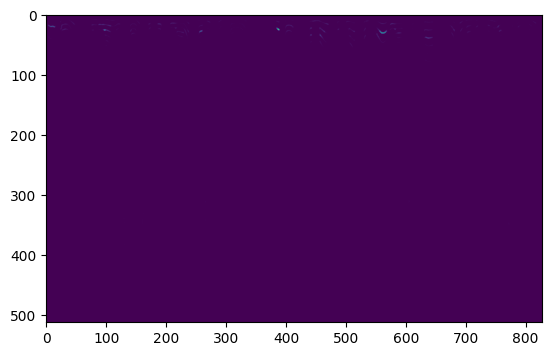

In [49]:
plt.imshow(spectrogram[0])

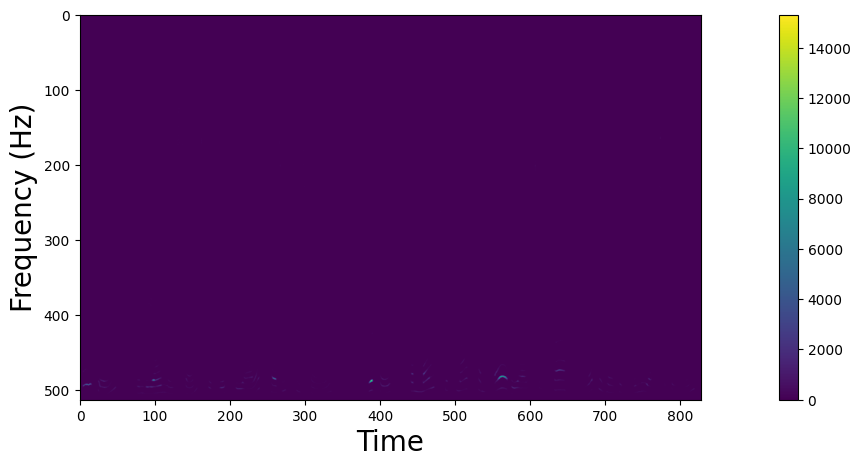

In [50]:
plt.figure(figsize=(20, 5))
plt.imshow(spectrogram.squeeze().data.numpy()[::-1,])
plt.xlabel('Time', size=20)
plt.ylabel('Frequency (Hz)', size=20)
plt.colorbar()

plt.show()


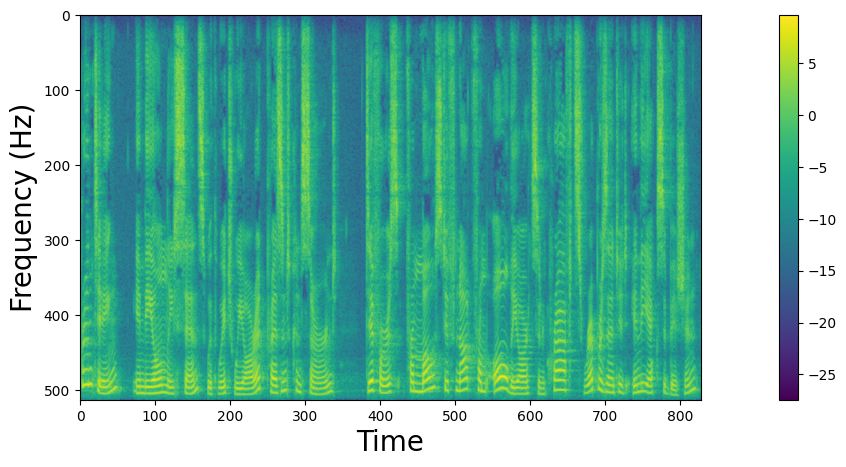

In [51]:
plt.figure(figsize=(20, 5))
plt.imshow(spectrogram.squeeze().log().data.numpy()[::-1,])
plt.xlabel('Time', size=20)
plt.ylabel('Frequency (Hz)', size=20)
plt.colorbar()

plt.show()


In [55]:
mel_scaler = torchaudio.transforms.MelScale(
    n_mels=80,
    sample_rate=22_050,
    n_stft=n_fft // 2 + 1
)

In [56]:
mel_scaler.fb.shape

torch.Size([513, 80])

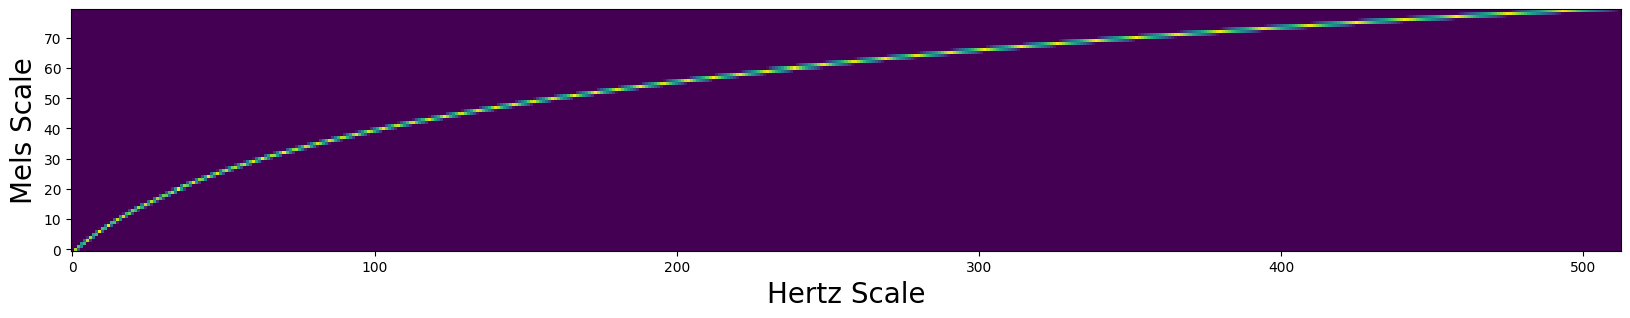

In [57]:
plt.figure(figsize=(20, 5))
plt.imshow(mel_scaler.fb.T)
plt.xlabel('Hertz Scale', size=20)
plt.ylabel('Mels Scale', size=20)
plt.gca().invert_yaxis()
plt.show()


In [58]:
mel_spectrogram = mel_scaler(spectrogram)


In [59]:
mel_spectrogram.shape


torch.Size([1, 80, 828])

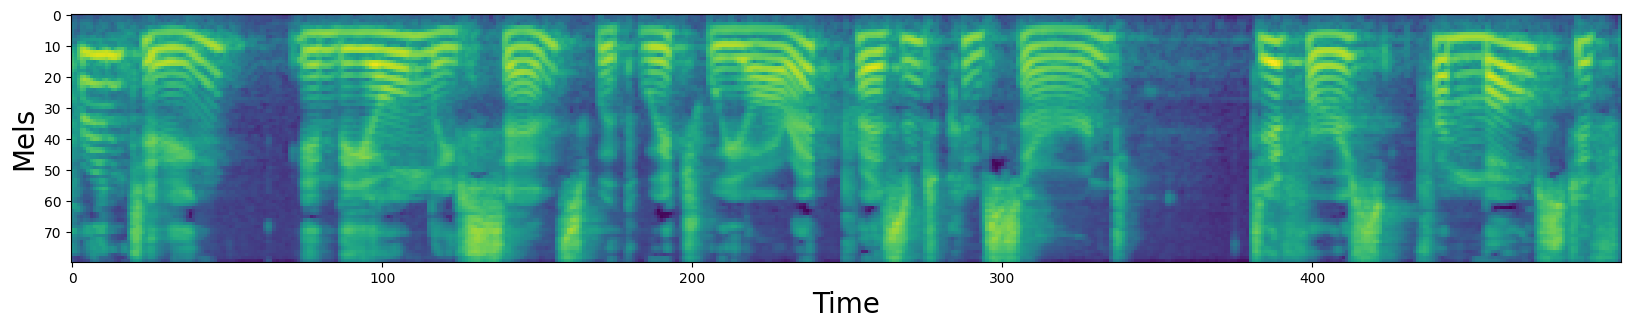

In [87]:
plt.figure(figsize=(20, 5))
plt.imshow(mel_spectrogram.squeeze().log()[:, :500])
plt.xlabel('Time', size=20)
plt.ylabel('Mels', size=20)
plt.show()

# Audio mnist classification

![](https://i.imgur.com/OX1ADxu.png)



Uncomment to download data

In [61]:
# !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1ouSOru91p-ZJCyI6E8cGh7N0r3vffi06' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1ouSOru91p-ZJCyI6E8cGh7N0r3vffi06" -O AudioMNIST.zip && rm -rf /tmp/cookies.txt

--2023-07-10 18:16:01--  https://docs.google.com/uc?export=download&confirm=t&id=1ouSOru91p-ZJCyI6E8cGh7N0r3vffi06
Resolving docs.google.com (docs.google.com)... 142.251.2.113, 142.251.2.139, 142.251.2.100, ...
Connecting to docs.google.com (docs.google.com)|142.251.2.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-00-3s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/7bmefb6h67rippn3s8eg2a41nkt3vgpn/1689012900000/05353592946685554048/*/1ouSOru91p-ZJCyI6E8cGh7N0r3vffi06?e=download&uuid=1708dc15-1c6d-4fdc-a5ef-eb2d2d13d5ab [following]
--2023-07-10 18:16:02--  https://doc-00-3s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/7bmefb6h67rippn3s8eg2a41nkt3vgpn/1689012900000/05353592946685554048/*/1ouSOru91p-ZJCyI6E8cGh7N0r3vffi06?e=download&uuid=1708dc15-1c6d-4fdc-a5ef-eb2d2d13d5ab
Resolving doc-00-3s-docs.googleusercontent.com (doc-00-3s-docs.googleusercontent.com)... 142.250.101.132, 260

Uncomment to unzip archive

In [62]:
# !unzip -q AudioMNIST.zip

In [63]:
from typing import List, Tuple

import pathlib
from tqdm import tqdm
from itertools import islice
from collections import defaultdict

import torch
import torch.nn.functional as F
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader, Subset


Определим класс AudioMnistDataset для загрузки данных. При загрузке извлечем из названия файла label аудио - произносимую цифру - первый символ в аудио до знака "_"



In [64]:
class AudioMnistDataset(Dataset):
    SR = 16_000

    """
    Each wavfile has the following format: digit_speackerid_wavid.wav
        For example, 6_01_47.wav:
            6 -- the number 6 is spoken
            01 -- the number is spoken by 1 speaker
            47 -- id of wavfile
    """

    def __init__(self, path_to_data: str):
        self.path_to_data = pathlib.Path(path_to_data)
        self.paths = list(self.path_to_data.rglob('?_*_*.wav'))

    def __getitem__(self, index: int):
        path_to_wav = self.paths[index].as_posix()

        # Load wav
        wav, sr = torchaudio.load(path_to_wav)

        label = int(path_to_wav.split('/')[-1].split('_')[0])

        return wav, label

    def __len__(self):
        return len(self.paths)


In [65]:
dataset = AudioMnistDataset('AudioMNIST')


In [66]:
wav, label = dataset[123]
label

0

In [71]:
dataset.SR

16000

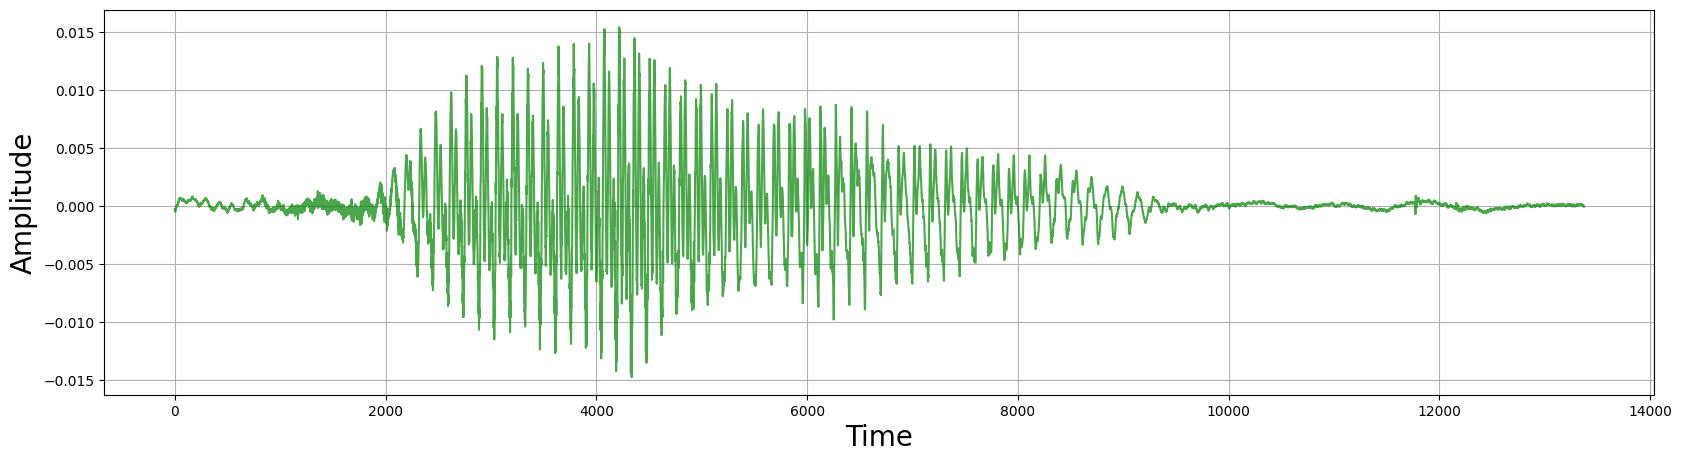

In [67]:
visualize_audio(wav, sr=dataset.SR)

Разобъем датасет на датасеты для трейна и валидации.



In [68]:
train_ratio = 0.9
train_size = int(len(dataset) * train_ratio)
validation_size = len(dataset) - train_size

indexes = torch.randperm(len(dataset))
train_indexes = indexes[:train_size]
validation_indexes = indexes[train_size:]

train_dataset = Subset(dataset, train_indexes)
validation_dataset = Subset(dataset, validation_indexes)

In [69]:
assert not set(train_indexes.tolist()).intersection(set(validation_indexes.tolist()))

Класс Collator объединяет аудиодорожки в один батч. Так как в нашей задаче все аудио разной длины, для того чтобы собрать в батч, заполним недостающее нулями (сделаем паддинг). Для этого создадим тензор из нулей размера [batch_size, max_wav_len] и заполним его элементами батча.



In [73]:
class Collator:

    def __call__(self, batch: List[Tuple[torch.Tensor, int]]):
        lengths = []
        wavs, labels = zip(*batch)

        for wav in wavs:
            lengths.append(wav.size(-1))

        max_len = max(lengths)
        batch_wavs = torch.zeros(len(batch), max_len)
        for i, wav in enumerate(wavs):
          batch_wavs[i, :lengths[i]] = wav

        labels = torch.tensor(labels).long()
        lengths = torch.tensor(lengths).long()

        return {
            'wav': batch_wavs,
            'label': labels,
            'length': lengths,
        }


In [74]:
train_dataloader = DataLoader(
    train_dataset, batch_size=32,
    shuffle=True, collate_fn=Collator(),
    num_workers=2, pin_memory=True
)

validation_dataloader = DataLoader(
    validation_dataset, batch_size=32,
    collate_fn=Collator(),
    num_workers=2, pin_memory=True
)

In [82]:
next(iter(train_dataloader))["wav"].shape

torch.Size([32, 13043])

Класс Featurizer делает необходимый в нашей задаче препроцессинг - считаем мел спектрограмму, логарифмирует ее и считает длину спектрограммы.



In [85]:
NUM_MELS = 80
HOP_LEN = 256
N_FFT = 1024
WIN_LEN = N_FFT
SAMPLE_RATE = 16000

In [93]:
class Featurizer(nn.Module):

    def __init__(self):
        super(Featurizer, self).__init__()

        self.featurizer = torchaudio.transforms.MelSpectrogram(
            sample_rate=SAMPLE_RATE,
            n_fft=N_FFT,
            win_length=WIN_LEN,
            hop_length=HOP_LEN,
            n_mels=NUM_MELS,
            center=True,
        )

    def forward(self, wav, length=None):
        mel_spectrogram = self.featurizer(wav)
        mel_spectrogram = mel_spectrogram.clamp(min=1e-5).log()

        if length is not None:
            length = (length - self.featurizer.win_length) // self.featurizer.hop_length
            # We add `4` because in MelSpectrogram center==True
            length += 4

            return mel_spectrogram, length

        return mel_spectrogram


В модель приходит батч размера [batch_size, num_mels, seq_len].

Последний слой - слой для классификации, возвращающий тензор размера [batch_size, NUM_CLASSES].


In [101]:
class Model(nn.Module):

    def __init__(self, input_dim, num_channels):
        super().__init__()
        self.input_dim = input_dim
        self.num_channels = num_channels
        self.convs = nn.Sequential(
            nn.Conv1d(in_channels=input_dim, out_channels=num_channels, kernel_size=17, stride=1),
            nn.BatchNorm1d(num_channels),
            nn.ReLU(),
            nn.Conv1d(in_channels=num_channels, out_channels=num_channels, kernel_size=11, stride=2),
            nn.BatchNorm1d(num_channels),
            nn.ReLU(),
                      )
        self.clf = nn.Linear(in_features=num_channels, out_features=10)

    def forward(self, inputs, length=None):
        # inputs of shape [batch_size, num_mels, seq_len]
        x = self.convs(inputs)
        x = x.mean(-1)
        x = self.clf(x)
        return x

Зададим параметры модели и оптимизатора и функцию потерь



In [102]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = Model(input_dim=NUM_MELS, num_channels=32).to(device)
featurizer = Featurizer().to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()


Создадим класс для подсчета метрики



In [103]:
class AverageMeter(object):
    """
    Computes and stores the average and current value
    """

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


In [104]:
storage = defaultdict(list)
num_epoch = 10

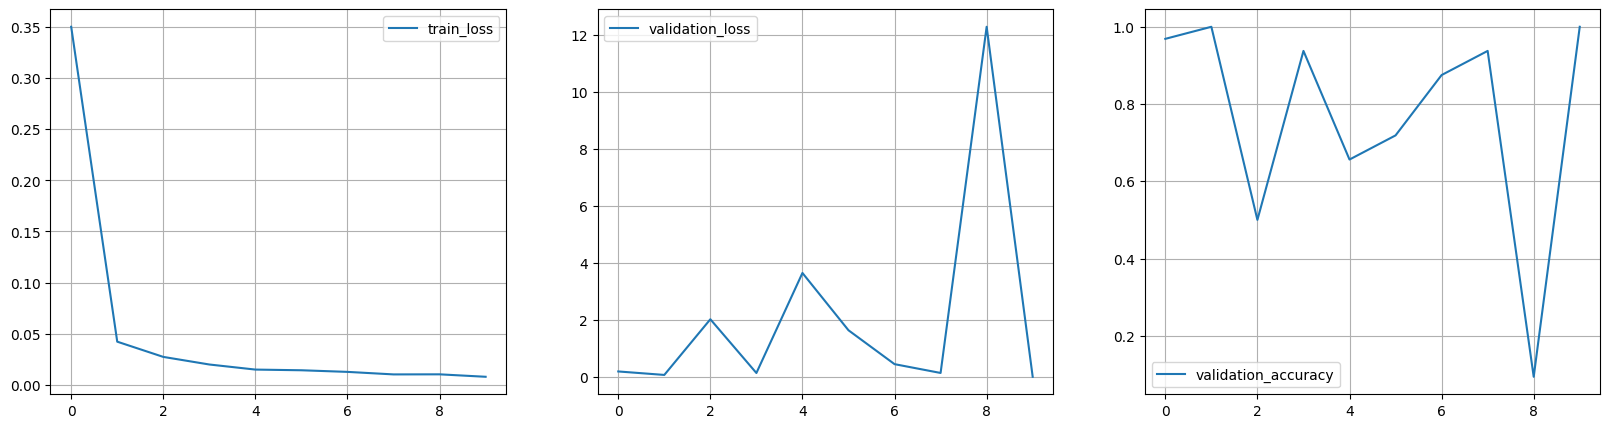

In [105]:
for epoch in range(num_epoch):
    train_loss_meter = AverageMeter()
    print(f"Epoch {epoch} out of {num_epoch}")

    model.train()
    for i, batch in enumerate(tqdm(train_dataloader)):
        # Move batch to device if device != 'cpu'
        wav = batch['wav'].to(device)
        length = batch['length'].to(device)
        label = batch['label'].to(device)

        # Compute mel spectrogram
        mel, mel_length = featurizer(wav, length)

        # feed model
        output = model(mel, mel_length)

        # compute loss
        loss = criterion(output, label)

        # zero out previously computed gradients
        optimizer.zero_grad()

        # compute gradients
        loss.backward()

        # update weights
        optimizer.step()

        # update metrics
        train_loss_meter.update(loss.item())

    storage['train_loss'].append(train_loss_meter.avg)

    validation_loss_meter = AverageMeter()
    validation_accuracy_meter = AverageMeter()

    model.eval()
    for i, batch in islice(enumerate(tqdm(validation_dataloader)), 1):
        # Move batch to device if device != 'cpu'
        wav = batch['wav'].to(device)
        length = batch['length'].to(device)
        label = batch['label'].to(device)

        # in inference mode we don't need to compute gradients
        # so we use `no_grad()` context manager to speed up inference
        with torch.no_grad():

            mel, mel_length = featurizer(wav, length)
            output = model(mel, mel_length)

            loss = criterion(output, label)

        # compute accuracy
        matches = (output.argmax(dim=-1) == label).float().mean()

        validation_loss_meter.update(loss.item())
        validation_accuracy_meter.update(matches.item())

    storage['validation_loss'].append(validation_loss_meter.avg)
    storage['validation_accuracy'].append(validation_accuracy_meter.avg)

    display.clear_output()

    fig, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].plot(storage['train_loss'], label='train_loss')
    axes[1].plot(storage['validation_loss'], label='validation_loss')

    axes[2].plot(storage['validation_accuracy'], label='validation_accuracy')

    for i in range(3):
        axes[i].grid()

        axes[i].legend()

    plt.show()


In [106]:
def inference(dataloader, take_n=10):
    """
    Display wav and results of NN
    """
    batch = next(iter(dataloader))
    # your code


In [ ]:
inference(validation_dataloader)